In [1]:
# Use some packages
import luxpy as lx
import numpy as np
from matplotlib import pyplot
from matplotlib import cm
from matplotlib.ticker import LinearLocator
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import LinearRegression
import random
from sigfig import round

E:\TTBV\Python\luxpy\luxpy\spectrum\basics\illuminants.py:512: RankWarning: Polyfit may be poorly conditioned
  xy, pxy, pxT_l7, pxT_L7, l7, L7 = _get_daylightlocus_parameters(ccts, spds, cieobs_)


In [2]:
from empir19nrm02 import _RES, _SPD
from empir19nrm02.f1prime import py_f1PrimeG, py_f1PrimeGlx
from empir19nrm02.tools import plotSelectedSPD, plotYxy, plotHist, plotCorrMatrixSmall, plotHistScales
from empir19nrm02.tools.help import strd, display_color_diagram, display_spectra, save_fig

## Read some detector and spd data from the empir19nrm02 package
<li>every entry (spectral responsivity, SPD is a row in the matrix, the first row is containing the wavelength scale)</li>
<li>For all data files in this project the first (sometimes also the second) data set(s) are used for referecne
calculations (e.g. for detectors the first one is V(Lambda) and for SPDs the first is standard illuminant A
and the second one sometimes illuminant L41)</li>

### Select the source data for simulation (change the entries in res_data (True/False for the required data sets)
### Detector Data
<li>VLDetectors: Current Collection</li>
<li>CIES025_VLDetectors: Collection from CIES025:2015</li>

In [3]:
res_data = { 'VLDetectors': True,
              'CIES025_VLDetectors': False
              }
detector_start_reading = True
detector_names = ''
print('Detector data base:')
for detector, enable in res_data.items():
    print('Name:', detector )
    print('    Size:', _RES[detector]['S']['data'].shape[0]-1 )
    print('    Use:', enable )
    if enable:
        detector_names = detector_names + detector + ' '
        if detector_start_reading:
            vldetectorsTemp=_RES[detector]['S']['data'].copy()
            wl_start = vldetectorsTemp[0].copy()
            detector_start_reading=False
        else:
            data_to_append = _RES[detector]['S']['data'].copy()
            interpolated_data = lx.cie_interp(data_to_append, wl_start, negative_values_allowed=True, kind='linear')
            vldetectorsTemp = np.vstack( (vldetectorsTemp, interpolated_data[1:]))

print( 'Detectors for the Simulation:')
print( '    Detectors:', detector_names)
print( '    Number of detectors:', vldetectorsTemp.shape[0]-1)

Detector data base:
Name: VLDetectors
    Size: 128
    Use: True
Name: CIES025_VLDetectors
    Size: 121
    Use: False
Detectors for the Simulation:
    Detectors: VLDetectors 
    Number of detectors: 128


In [4]:
bInterpol = True
if bInterpol:
    wl_interpol = lx.getwlr([380,780,1])
    vldetectors=lx.cie_interp(vldetectorsTemp, wl_interpol, negative_values_allowed=True, kind='S')
else:
    vldetectors=vldetectorsTemp

print( vldetectorsTemp.shape)
print( vldetectors.shape)

out_dir = 'SMCF_L41'

(129, 81)
(129, 401)


### Select the SPD data for simulation (change the entries in spd_data (True/False for the required data sets)
### SPD Data
<li>BB: Collection of Blackbody SPDs </li>
<li>PTLED':  Collection of PT White LEDs</li>
<li>CIES025_PTLED':  Collection of PT White LEDs used in CIES025:2015</li>
<li>OSRAM_PTLED':  Collection of PT White LEDs from OSRAM</li>
<li>RGBLED':  Collection of RGB White LEDs</li>
<li>CIES025_RGBLED':  Collection of RGB White LEDs used in CIES025:2015</li>
<li>PHOTOLED':  Collection of PT White LEDs from the PhotoLED-Project</li>
<li>MONOLED':  Collection of Monochrome LEDs</li>
<li>OSRAM_MONOLED':  Collection of Monochrome LEDs from OSRAM</li>

In [5]:
spd_data = {'BB': False,
            'PTLED': False,
            'CIES025_PTLED': False,
            'OSRAM_PTLED': False,
            'RGBLED':  False,
            'CIES025_RGBLED':  False,
            'PHOTOLED':  True,
            'MONOLED':  False,
            'OSRAM_MONOLED':  False}


spd_start_reading = True
spd_names = ''
print('SPD data base:')
for spd, enable in spd_data.items():
    print('Name:', spd, '\t\t\t', 'Size:', _SPD[spd]['S']['data'].shape[0]-1, '\t\t', 'Use:', enable)
    if enable:
        spd_names = spd_names + spd + ' '
        if spd_start_reading:
            spectra=_SPD[spd]['S']['data'].copy()
            wl_start = spectra[0].copy()
            spd_start_reading=False
        else:
            data_to_append = _SPD[spd]['S']['data'].copy()
            interpolated_data = lx.cie_interp(data_to_append, wl_start, negative_values_allowed=True, kind='S')
            spectra = np.vstack( (spectra, interpolated_data))

print( '\nSPDs for the Simulation:')
print( '    SPD:', spd_names)
print( '    Number of spds:', spectra.shape[0]-1)

SPD data base:
Name: BB 			 Size: 55 		 Use: False
Name: PTLED 			 Size: 229 		 Use: False
Name: CIES025_PTLED 			 Size: 228 		 Use: False
Name: OSRAM_PTLED 			 Size: 137 		 Use: False
Name: RGBLED 			 Size: 98 		 Use: False
Name: CIES025_RGBLED 			 Size: 97 		 Use: False
Name: PHOTOLED 			 Size: 1496 		 Use: True
Name: MONOLED 			 Size: 638 		 Use: False
Name: OSRAM_MONOLED 			 Size: 260 		 Use: False

SPDs for the Simulation:
    SPD: PHOTOLED 
    Number of spds: 1496


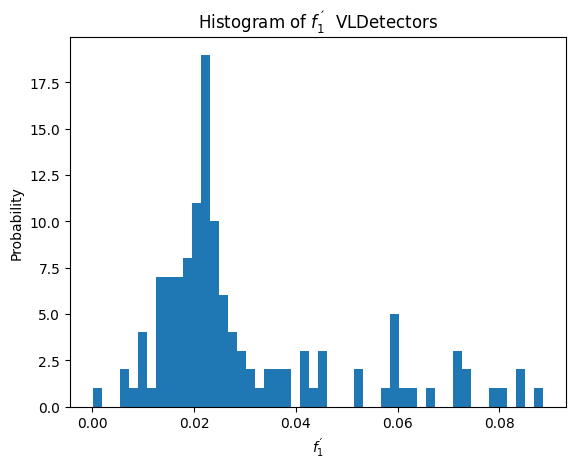

In [6]:
f1p=lx.spectral_mismatch_and_uncertainty.f1prime(vldetectors, S_C='A', cieobs='1931_2', s_target_index=2)
plotHist( f1p, xLabel='$f_{1}^{´}$', yLabel='Probability', title='Histogram of $f_{1}^{´}$  ' + detector_names)
save_fig( out_dir, 'Detectorf1pHist')

### Sort the detectors on their $f_{1}^{'}$ values to make the visualization easier

In [7]:
vldetectors[1:]=vldetectors[np.argsort(f1p)+1]
f1p=lx.spectral_mismatch_and_uncertainty.f1prime(vldetectors, S_C='A', cieobs='1931_2', s_target_index=2)

## Let's work with the SPDs selected above


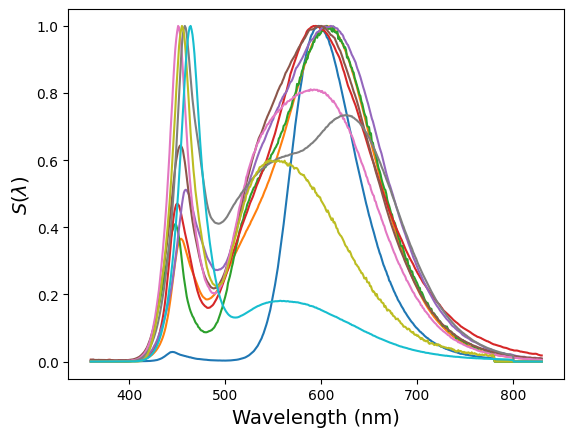

In [8]:
display_spectra(spd_names, spectra)
save_fig( out_dir, 'Spectra')

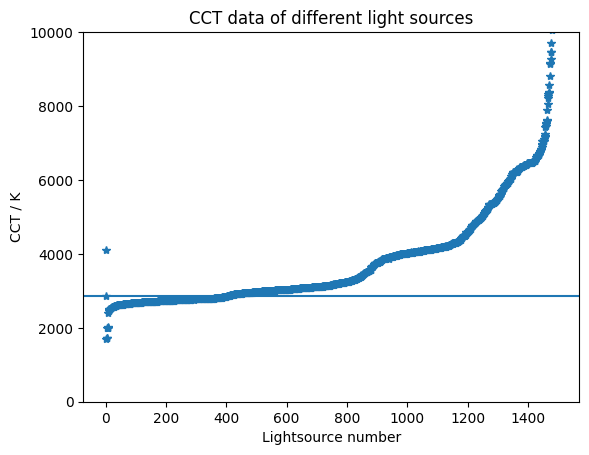

In [9]:
cct = lx.xyz_to_cct(lx.spd_to_xyz(spectra))
pyplot.plot(cct, "*")
pyplot.xlabel('Lightsource number')
pyplot.ylabel('CCT / K')
pyplot.ylim(0,10000)
pyplot.axhline(2856)
pyplot.title('CCT data of different light sources')
save_fig( out_dir, 'SD_CCT')


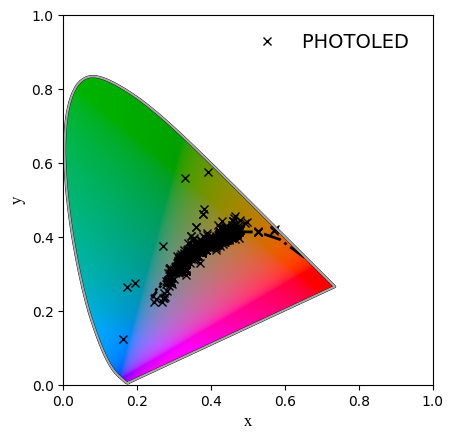

In [10]:
display_color_diagram(spd_names, spectra,cspace='Yxy')
save_fig( out_dir, 'Yxy')

### SMCF calculation for the selected SPDs

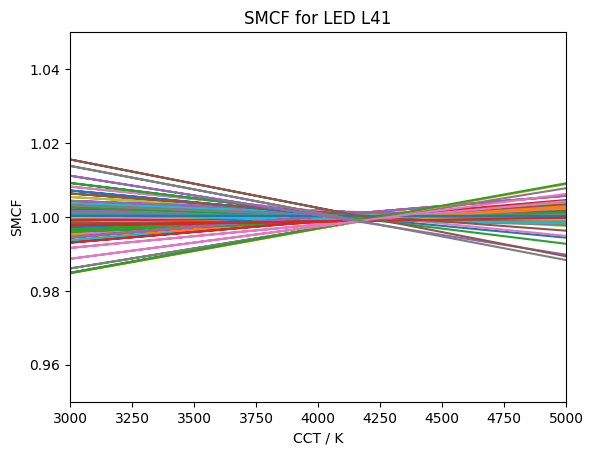

In [11]:
Tmin = 3000
Tmax = 5000
SMCFLED=lx.spectral_mismatch_and_uncertainty.get_spectral_mismatch_correction_factors( spectra, vldetectors, S_C='LED_L41')
SMCFLED.shape
fig, ax = pyplot.subplots()
# get the index values where ccts are from 3000 to 5000 K
shrink_indexes = np.where((cct>Tmin) & (cct<Tmax))[0]
result = np.ndarray((3, SMCFLED.shape[1]))
result[0] = f1p
for i in range(SMCFLED.shape[1]):
    reg = LinearRegression().fit(cct[shrink_indexes].reshape(-1, 1), SMCFLED[shrink_indexes,i])
    result[1, i] = reg.coef_[0]
    result[2, i] = reg.intercept_
    # plot the regression
    ax.plot(cct[shrink_indexes], reg.predict(cct[shrink_indexes].reshape(-1, 1)))
ax.set_xlabel('CCT / K')
ax.set_ylabel('SMCF')
pyplot.title('SMCF for LED L41')
ax.set_xlim(Tmin,Tmax)
ax.set_ylim(0.95,1.05)
save_fig( out_dir, 'SMCF_LED_L41reg')


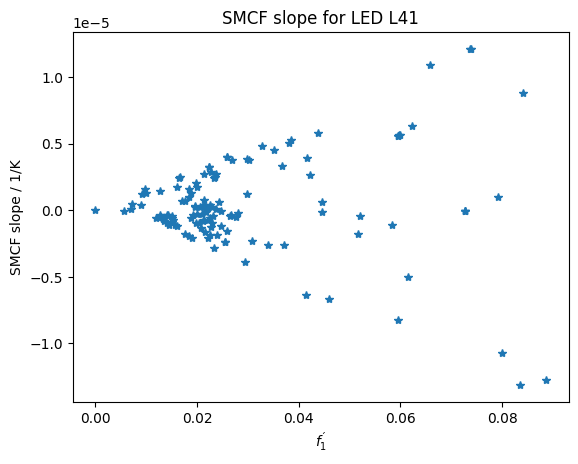

In [12]:
pyplot.plot(result[0], result[1], "*")
pyplot.xlabel(strd['f1p'])
pyplot.ylabel("SMCF slope / 1/K")
pyplot.title('SMCF slope for LED L41')
save_fig( out_dir, 'SMCF_LED_L41_slope')

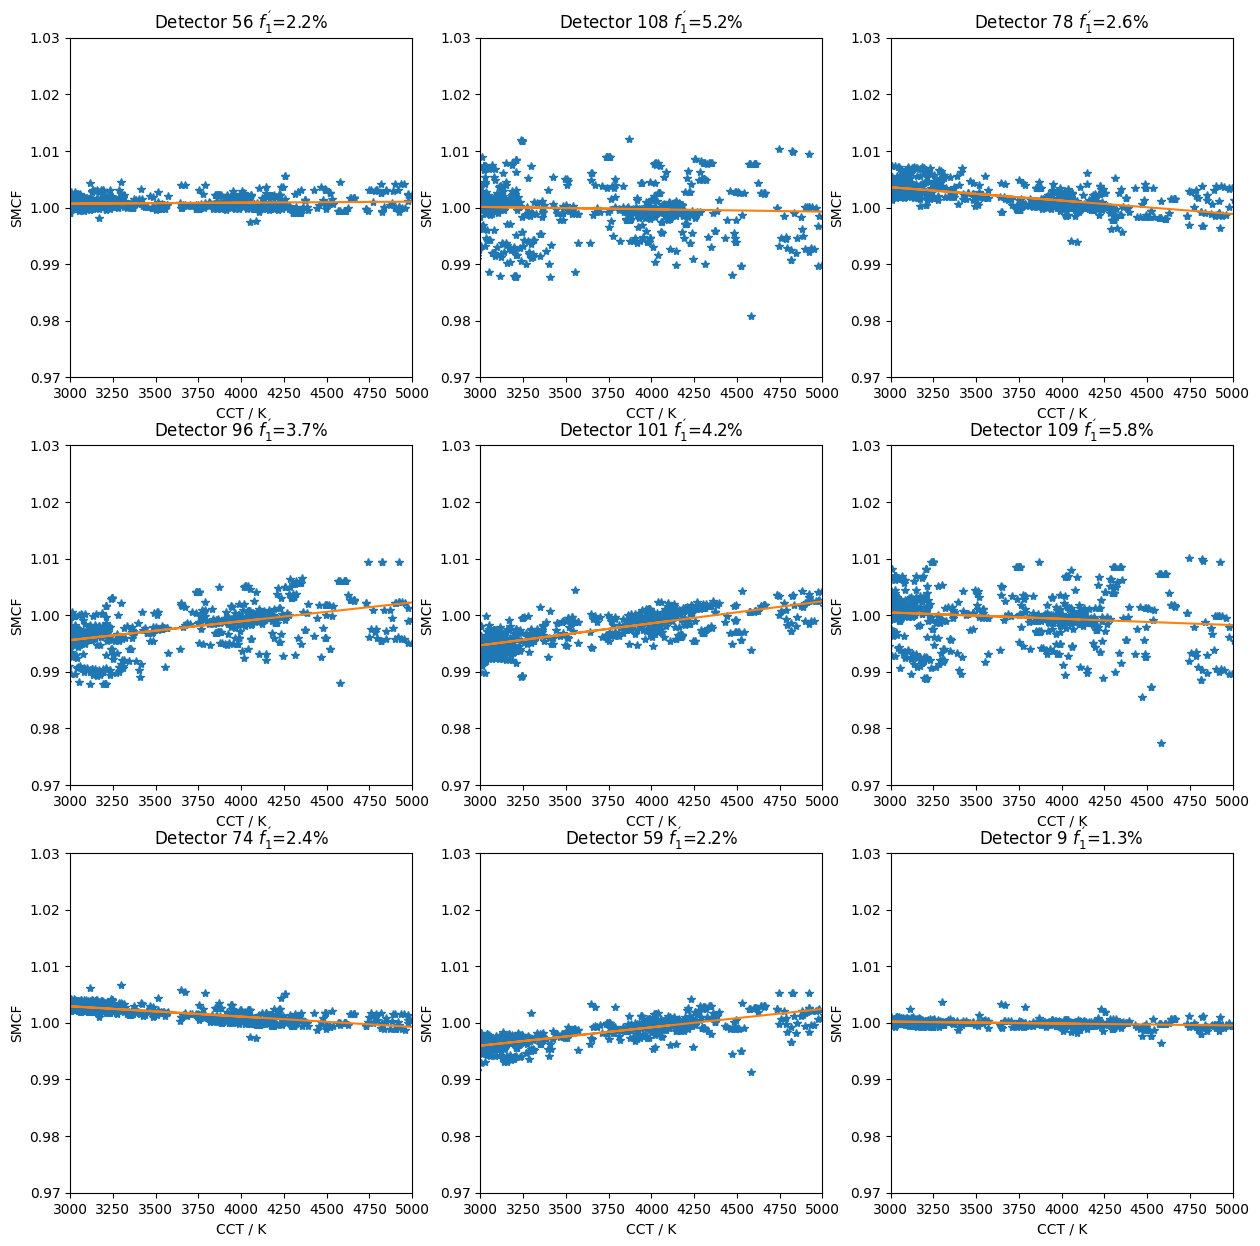

In [13]:
# wähle zufällig 9 detektoren aus
random_detectors = random.sample(range(vldetectors.shape[0]-1), 9)
# bereite 3x3 polts vor
fig, axs = pyplot.subplots(3, 3, figsize=(15,15))
for i in range(3):
    for j in range(3):
        current_detector = random_detectors[i*3+j]
        # plotte die SMCFs für die zufällig ausgewählten detektoren
        axs[i, j].plot(cct, SMCFLED[:,current_detector], "*")
        # zeige die lineare regression an
        axs[i, j].plot(cct[shrink_indexes], result[1, current_detector]*cct[shrink_indexes]+result[2, current_detector])
        axs[i, j].set_title('Detector ' + str(current_detector) + ' ' + strd['f1p'] +'=' + str(round(f1p[current_detector]*100, 2)) + '%')
        axs[i, j].set_xlim(Tmin,Tmax)
        axs[i, j].set_xlabel('CCT / K')
        axs[i, j].set_ylabel('SMCF')
        axs[i, j].set_ylim(0.97,1.03)

save_fig( out_dir, 'SMCF_LED_L41_detectors')
